Notebook for the article [Stop Loss, Trailing Stop, or Take Profit? 2 Million Backtests Shed Light](https://polakowo.medium.com/stop-loss-trailing-stop-or-take-profit-2-million-backtests-shed-light-dde23bda40be).

In [1]:
import vectorbt as vbt

import numpy as np
import pandas as pd
import itertools
from datetime import datetime, timedelta
from numba import njit
import ipywidgets

seed = 42
symbols = [
    'BTC-USD', 'ETH-USD', 'XRP-USD', 'BCH-USD', 'LTC-USD', 
    'BNB-USD', 'EOS-USD', 'XLM-USD', 'XMR-USD', 'ADA-USD'
]
start_date = datetime(2018, 1, 1)
end_date = datetime(2021, 1, 1)
time_delta = end_date - start_date
window_len = timedelta(days=180)
window_count = 400
exit_types = ['SL', 'TS', 'TP', 'Random', 'Holding']
step = 0.01  # 1%
stops = np.arange(step, 1 + step, step)

vbt.settings.layout['template'] = vbt.settings.dark_template

vbt.settings.portfolio['freq'] = '1D'
vbt.settings.portfolio['init_cash'] = 100.  # 100$
vbt.settings.portfolio['fees'] = 0.0025  # 0.25%
vbt.settings.portfolio['slippage'] = 0.0025  # 0.25%

print(pd.Series({
    'Start date': start_date,
    'End date': end_date,
    'Time period (days)': time_delta.days,
    'Assets': len(symbols),
    'Window length': window_len,
    'Windows': window_count,
    'Exit types': len(exit_types),
    'Stop values': len(stops),
    'Tests per asset': window_count * len(stops) * len(exit_types),
    'Tests per window': len(symbols) * len(stops) * len(exit_types),
    'Tests per exit type': len(symbols) * window_count * len(stops),
    'Tests per stop type and value': len(symbols) * window_count,
    'Tests total': len(symbols) * window_count * len(stops) * len(exit_types)
}))

Start date                       2018-01-01 00:00:00
End date                         2021-01-01 00:00:00
Time period (days)                              1096
Assets                                            10
Window length                      180 days, 0:00:00
Windows                                          400
Exit types                                         5
Stop values                                      100
Tests per asset                               200000
Tests per window                                5000
Tests per exit type                           400000
Tests per stop type and value                   4000
Tests total                                  2000000
dtype: object


In [5]:
cols = ['Open', 'Low', 'High', 'Close', 'Volume']
yfdata = vbt.YFData.download(symbols, start=start_date, end=end_date)

print(yfdata.data.keys())
print(yfdata.data['BTC-USD'].shape)

dict_keys(['BTC-USD', 'ETH-USD', 'XRP-USD', 'BCH-USD', 'LTC-USD', 'BNB-USD', 'EOS-USD', 'XLM-USD', 'XMR-USD', 'ADA-USD'])
(1093, 7)


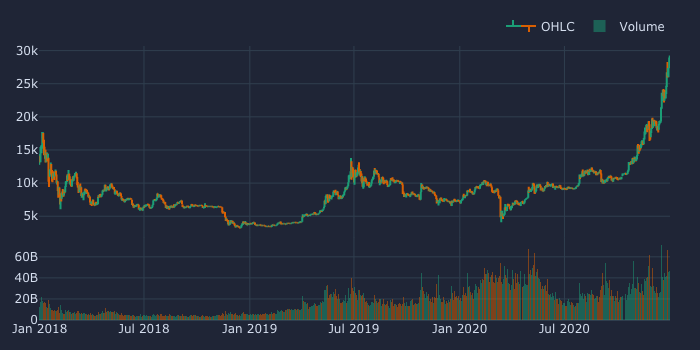

In [6]:
yfdata.data['BTC-USD'].vbt.ohlcv.plot().show_png()

In [7]:
ohlcv = yfdata.concat()

print(ohlcv.keys())
print(ohlcv['Open'].shape)

dict_keys(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])
(1093, 10)


In [8]:
split_ohlcv = {}
for k, v in ohlcv.items():
    split_df, split_indexes = v.vbt.range_split(range_len=window_len.days, n=window_count) 
    split_ohlcv[k] = split_df
ohlcv = split_ohlcv
    
print(ohlcv['Open'].shape)

(180, 4000)


In [9]:
print(ohlcv['Open'].columns)

MultiIndex([(  0, 'BTC-USD'),
            (  0, 'ETH-USD'),
            (  0, 'XRP-USD'),
            (  0, 'BCH-USD'),
            (  0, 'LTC-USD'),
            (  0, 'BNB-USD'),
            (  0, 'EOS-USD'),
            (  0, 'XLM-USD'),
            (  0, 'XMR-USD'),
            (  0, 'ADA-USD'),
            ...
            (399, 'BTC-USD'),
            (399, 'ETH-USD'),
            (399, 'XRP-USD'),
            (399, 'BCH-USD'),
            (399, 'LTC-USD'),
            (399, 'BNB-USD'),
            (399, 'EOS-USD'),
            (399, 'XLM-USD'),
            (399, 'XMR-USD'),
            (399, 'ADA-USD')],
           names=['split_idx', 'symbol'], length=4000)


In [10]:
entries = pd.DataFrame.vbt.signals.empty_like(ohlcv['Open'])
entries.iloc[0, :] = True

print(entries.shape)

(180, 4000)


In [11]:
sl_exits = vbt.OHLCSTEX.run(
    entries, 
    ohlcv['Open'], 
    ohlcv['High'], 
    ohlcv['Low'], 
    ohlcv['Close'], 
    sl_stop=list(stops),
    stop_type=None, hit_price=None
).exits
ts_exits = vbt.OHLCSTEX.run(
    entries, 
    ohlcv['Open'], 
    ohlcv['High'], 
    ohlcv['Low'], 
    ohlcv['Close'], 
    ts_stop=list(stops),
    stop_type=None, hit_price=None
).exits
tp_exits = vbt.OHLCSTEX.run(
    entries, 
    ohlcv['Open'], 
    ohlcv['High'], 
    ohlcv['Low'], 
    ohlcv['Close'], 
    tp_stop=list(stops),
    stop_type=None, hit_price=None
).exits

print(sl_exits.shape, ts_exits.shape, tp_exits.shape)

(180, 400000) (180, 400000) (180, 400000)


In [12]:
sl_exits.columns.rename('stop_value', level='ohlcstex_sl_stop', inplace=True)
ts_exits.columns.rename('stop_value', level='ohlcstex_ts_stop', inplace=True)
tp_exits.columns.rename('stop_value', level='ohlcstex_tp_stop', inplace=True)

print(sl_exits.columns)

MultiIndex([(0.01,   0, 'BTC-USD'),
            (0.01,   0, 'ETH-USD'),
            (0.01,   0, 'XRP-USD'),
            (0.01,   0, 'BCH-USD'),
            (0.01,   0, 'LTC-USD'),
            (0.01,   0, 'BNB-USD'),
            (0.01,   0, 'EOS-USD'),
            (0.01,   0, 'XLM-USD'),
            (0.01,   0, 'XMR-USD'),
            (0.01,   0, 'ADA-USD'),
            ...
            ( 1.0, 399, 'BTC-USD'),
            ( 1.0, 399, 'ETH-USD'),
            ( 1.0, 399, 'XRP-USD'),
            ( 1.0, 399, 'BCH-USD'),
            ( 1.0, 399, 'LTC-USD'),
            ( 1.0, 399, 'BNB-USD'),
            ( 1.0, 399, 'EOS-USD'),
            ( 1.0, 399, 'XLM-USD'),
            ( 1.0, 399, 'XMR-USD'),
            ( 1.0, 399, 'ADA-USD')],
           names=['stop_value', 'split_idx', 'symbol'], length=400000)


SL    0.430843
TS    0.589160
TP    0.519423
Name: avg_num_signals, dtype: float64


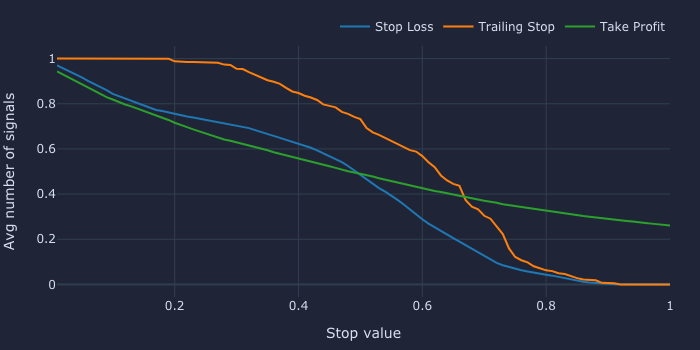

In [13]:
print(pd.Series({
    'SL': sl_exits.vbt.signals.num_signals().mean(),
    'TS': ts_exits.vbt.signals.num_signals().mean(),
    'TP': tp_exits.vbt.signals.num_signals().mean()
}, name='avg_num_signals'))

pd.DataFrame({
    'Stop Loss': sl_exits.vbt.signals.num_signals().groupby('stop_value').mean(),
    'Trailing Stop': ts_exits.vbt.signals.num_signals().groupby('stop_value').mean(),
    'Take Profit': tp_exits.vbt.signals.num_signals().groupby('stop_value').mean()
}).vbt.plot(xaxis_title='Stop value', yaxis_title='Avg number of signals').show_png()

In [14]:
sl_exits.iloc[-1, :] = True
ts_exits.iloc[-1, :] = True
tp_exits.iloc[-1, :] = True

sl_exits = sl_exits.vbt.signals.first(reset_by=entries, allow_gaps=True)
ts_exits = ts_exits.vbt.signals.first(reset_by=entries, allow_gaps=True)
tp_exits = tp_exits.vbt.signals.first(reset_by=entries, allow_gaps=True)

print(pd.Series({
    'SL': sl_exits.vbt.signals.num_signals().mean(),
    'TS': ts_exits.vbt.signals.num_signals().mean(),
    'TP': tp_exits.vbt.signals.num_signals().mean()
}, name='avg_num_signals'))

SL    1.0
TS    1.0
TP    1.0
Name: avg_num_signals, dtype: float64


In [15]:
hold_exits = pd.DataFrame.vbt.signals.empty_like(sl_exits)
hold_exits.iloc[-1, :] = True

print(hold_exits.shape)

(180, 400000)


In [16]:
rand_exits = hold_exits.vbt.shuffle(seed=seed)

print(rand_exits.shape)

(180, 400000)


In [17]:
exits = pd.DataFrame.vbt.concat(
    sl_exits, 
    ts_exits, 
    tp_exits, 
    rand_exits, 
    hold_exits, 
    keys=pd.Index(exit_types, name='exit_type')
)

print(exits.shape)

(180, 2000000)


In [18]:
print(exits.columns)

MultiIndex([(     'SL', 0.01,   0, 'BTC-USD'),
            (     'SL', 0.01,   0, 'ETH-USD'),
            (     'SL', 0.01,   0, 'XRP-USD'),
            (     'SL', 0.01,   0, 'BCH-USD'),
            (     'SL', 0.01,   0, 'LTC-USD'),
            (     'SL', 0.01,   0, 'BNB-USD'),
            (     'SL', 0.01,   0, 'EOS-USD'),
            (     'SL', 0.01,   0, 'XLM-USD'),
            (     'SL', 0.01,   0, 'XMR-USD'),
            (     'SL', 0.01,   0, 'ADA-USD'),
            ...
            ('Holding',  1.0, 399, 'BTC-USD'),
            ('Holding',  1.0, 399, 'ETH-USD'),
            ('Holding',  1.0, 399, 'XRP-USD'),
            ('Holding',  1.0, 399, 'BCH-USD'),
            ('Holding',  1.0, 399, 'LTC-USD'),
            ('Holding',  1.0, 399, 'BNB-USD'),
            ('Holding',  1.0, 399, 'EOS-USD'),
            ('Holding',  1.0, 399, 'XLM-USD'),
            ('Holding',  1.0, 399, 'XMR-USD'),
            ('Holding',  1.0, 399, 'ADA-USD')],
           names=['exit_type', 'stop_value'

exit_type
Holding    179.000000
Random      89.929929
SL         124.231990
TP         113.666125
TS         103.607388
dtype: float64


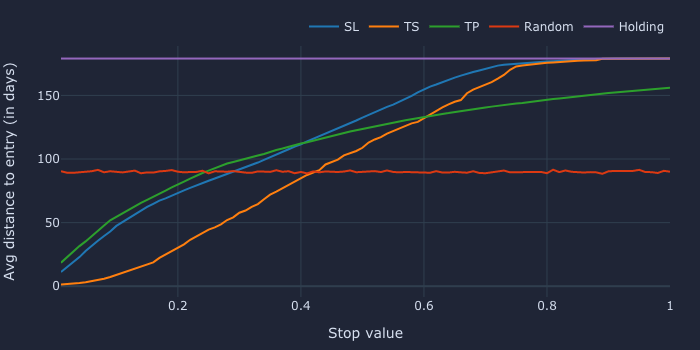

In [19]:
@njit
def distance_map_nb(entry_i, exit_i, col):
    return exit_i - entry_i

@njit
def avg_reduce_nb(col, a):
    return np.nanmean(a)

avg_distance = entries.vbt.signals.map_reduce_between(
    other=exits, 
    map_func_nb=distance_map_nb,
    reduce_func_nb=avg_reduce_nb
).groupby(['exit_type', 'stop_value']).mean().unstack(level='exit_type')

print(avg_distance.mean())

avg_distance[exit_types].vbt.plot(
    xaxis_title='Stop value', 
    yaxis_title='Avg distance to entry (in days)'
).show_png()

In [20]:
# portfolio = vbt.Portfolio.from_signals(ohlcv['Close'], entries, exits)

# print(len(portfolio.orders()))

In [21]:
# del portfolio

from tqdm import tqdm
import gc

total_returns = []

for i in tqdm(range(len(exit_types))):
    chunk_mask = exits.columns.get_level_values('exit_type') == exit_types[i]
    chunk_exits = exits.loc[:, chunk_mask]
    chunk_portfolio = vbt.Portfolio.from_signals(ohlcv['Close'], entries, chunk_exits)
    total_returns.append(chunk_portfolio.total_return())
    
    del chunk_portfolio
    gc.collect()
    
total_return = pd.concat(total_returns)

print(total_return.shape)

100%|██████████| 5/5 [00:35<00:00,  7.51s/it]


(2000000,)


count    400000.000000
mean          0.084511
std           0.825378
min          -0.910154
50%          -0.138830
max           6.490103
Name: Holding, dtype: float64


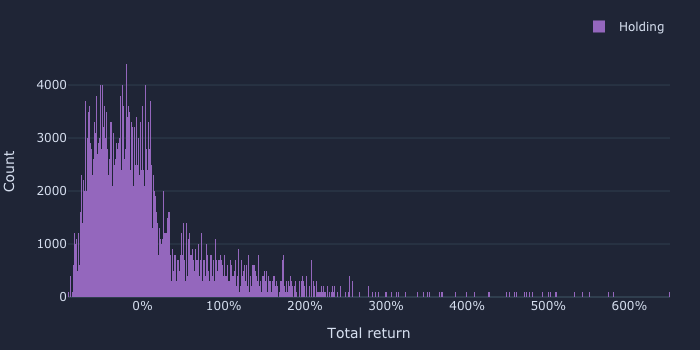

In [22]:
total_return_by_type = total_return.unstack(level='exit_type')[exit_types]

print(total_return_by_type['Holding'].describe(percentiles=[]))

total_return_by_type['Holding'].vbt.histplot(
    xaxis_title='Total return',
    xaxis_tickformat='%',
    yaxis_title='Count',
    trace_kwargs=dict(marker_color=vbt.settings.color_schema['purple'])
).show_png()

               Mean    Median       Std
exit_type                              
SL         0.049089 -0.164551  0.762460
TS         0.049979 -0.106527  0.694567
TP         0.045678  0.078079  0.480241
Random     0.023861 -0.076682  0.575014
Holding    0.084511 -0.138830  0.825378


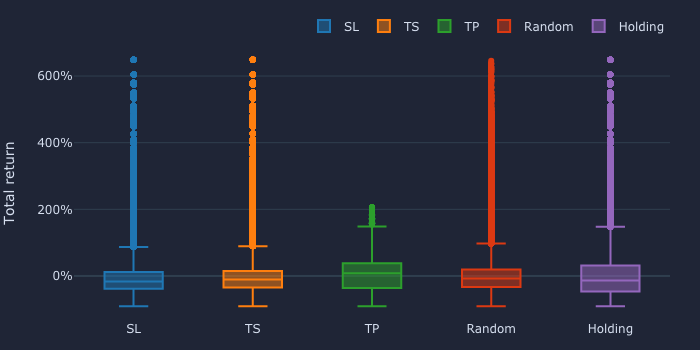

In [23]:
print(pd.DataFrame({
    'Mean': total_return_by_type.mean(),
    'Median': total_return_by_type.median(),
    'Std': total_return_by_type.std(),
}))

total_return_by_type.vbt.boxplot(
    yaxis_title='Total return',
    yaxis_tickformat='%'
).show_png()

In [24]:
print((total_return_by_type > 0).mean().rename('win_rate'))

exit_type
SL         0.314605
TS         0.359727
TP         0.574222
Random     0.404245
Holding    0.401250
Name: win_rate, dtype: float64


exit_type
SL         4.908914
TS         4.997897
TP         4.567793
Random     2.219848
Holding    8.451119
dtype: float64


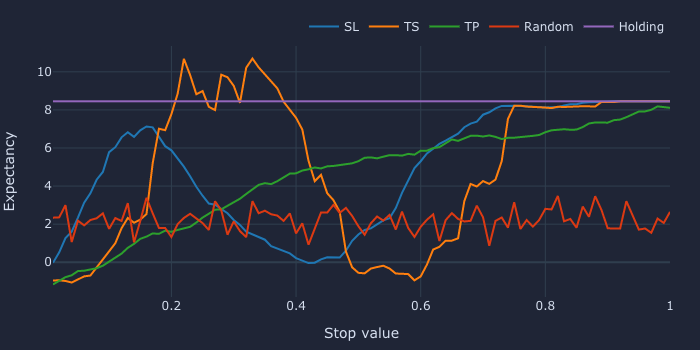

In [25]:
init_cash = vbt.settings.portfolio['init_cash']

def get_expectancy(total_return_by_type, level_name):
    grouped = total_return_by_type.groupby(level_name, axis=0)
    win_rate = grouped.apply(lambda x: (x > 0).mean())
    avg_win = grouped.apply(lambda x: init_cash * x[x > 0].mean()).fillna(0)
    avg_loss = grouped.apply(lambda x: init_cash * x[x < 0].mean()).fillna(0)
    return win_rate * avg_win - (1 - win_rate) * np.abs(avg_loss)
    
expectancy_by_stop = get_expectancy(total_return_by_type, 'stop_value')

print(expectancy_by_stop.mean())

expectancy_by_stop.vbt.plot(
    xaxis_title='Stop value', 
    yaxis_title='Expectancy'
).show_png()

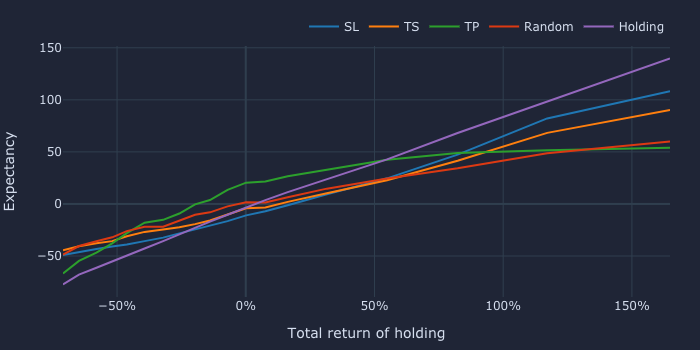

In [26]:
return_values = np.sort(total_return_by_type['Holding'].values)
idxs = np.ceil(np.linspace(0, len(return_values) - 1, 21)).astype(int)
bins = return_values[idxs][:-1]

def bin_return(total_return_by_type):
    classes = pd.cut(total_return_by_type['Holding'], bins=bins, right=True)
    new_level = pd.Index(np.array(classes.apply(lambda x: x.right)), name='bin_right')
    return total_return_by_type.vbt.stack_index(new_level, axis=0)

binned_total_return_by_type = bin_return(total_return_by_type)

expectancy_by_bin = get_expectancy(binned_total_return_by_type, 'bin_right')

expectancy_by_bin.vbt.plot(
    trace_kwargs=dict(mode='lines'),
    xaxis_title='Total return of holding',
    xaxis_tickformat='%',
    yaxis_title='Expectancy'
).show_png()

In [28]:
range_starts = pd.DatetimeIndex(list(map(lambda x: x[0], split_indexes)))
range_ends = pd.DatetimeIndex(list(map(lambda x: x[-1], split_indexes)))

symbol_lvl = total_return_by_type.index.get_level_values('symbol')
split_idx_lvl = total_return_by_type.index.get_level_values('split_idx')
range_start_lvl = range_starts[split_idx_lvl]
range_end_lvl = range_ends[split_idx_lvl]

asset_multi_select = ipywidgets.SelectMultiple(
    options=symbols,
    value=symbols,
    rows=len(symbols),
    description='Symbols'
)
dates = np.unique(yfdata.wrapper.index)
date_range_slider = ipywidgets.SelectionRangeSlider(
    options=dates,
    index=(0, len(dates)-1),
    orientation='horizontal',
    readout=False,
    continuous_update=False
)
range_start_label = ipywidgets.Label()
range_end_label = ipywidgets.Label()
metric_dropdown = ipywidgets.Dropdown(
    options=['Mean', 'Median', 'Win Rate', 'Expectancy'],
    value='Expectancy'
)
stop_scatter = vbt.plotting.Scatter(
    trace_names=exit_types,
    x_labels=stops, 
    xaxis_title='Stop value', 
    yaxis_title='Expectancy'
)
stop_scatter_img = ipywidgets.Image(
    format='png',
    width=stop_scatter.fig.layout.width,
    height=stop_scatter.fig.layout.height
)
bin_scatter = vbt.plotting.Scatter(
    trace_names=exit_types,
    x_labels=expectancy_by_bin.index, 
    trace_kwargs=dict(mode='lines'),
    xaxis_title='Total return of holding',
    xaxis_tickformat='%',
    yaxis_title='Expectancy'
)
bin_scatter_img = ipywidgets.Image(
    format='png',
    width=bin_scatter.fig.layout.width,
    height=bin_scatter.fig.layout.height
)

In [29]:
def update_scatter(*args, **kwargs):
    _symbols = asset_multi_select.value
    _from = date_range_slider.value[0]
    _to = date_range_slider.value[1]
    _metric_name = metric_dropdown.value
    
    range_mask = (range_start_lvl >= _from) & (range_end_lvl <= _to)
    asset_mask = symbol_lvl.isin(_symbols)
    filtered = total_return_by_type[range_mask & asset_mask]
    
    filtered_binned = bin_return(filtered)
    if _metric_name == 'Mean':
        filtered_metric = filtered.groupby('stop_value').mean()
        filtered_bin_metric = filtered_binned.groupby('bin_right').mean()
    elif _metric_name == 'Median':
        filtered_metric = filtered.groupby('stop_value').median()
        filtered_bin_metric = filtered_binned.groupby('bin_right').median()
    elif _metric_name == 'Win Rate':
        filtered_metric = (filtered > 0).groupby('stop_value').mean()
        filtered_bin_metric = (filtered_binned > 0).groupby('bin_right').mean()
    elif _metric_name == 'Expectancy':
        filtered_metric = get_expectancy(filtered, 'stop_value')
        filtered_bin_metric = get_expectancy(filtered_binned, 'bin_right')
        
    stop_scatter.fig.update_layout(yaxis_title=_metric_name)
    stop_scatter.update(filtered_metric)
    stop_scatter_img.value = stop_scatter.fig.to_image(format="png")
    
    bin_scatter.fig.update_layout(yaxis_title=_metric_name)
    bin_scatter.update(filtered_bin_metric)
    bin_scatter_img.value = bin_scatter.fig.to_image(format="png")
    
    range_start_label.value = np.datetime_as_string(_from, unit='D')
    range_end_label.value = np.datetime_as_string(_to, unit='D')
    
asset_multi_select.observe(update_scatter, names='value')
date_range_slider.observe(update_scatter, names='value')
metric_dropdown.observe(update_scatter, names='value')
update_scatter()

In [30]:
dashboard = ipywidgets.VBox([
    asset_multi_select,
    ipywidgets.HBox([
        range_start_label,
        date_range_slider,
        range_end_label
    ]),
    metric_dropdown,
    stop_scatter_img,
    bin_scatter_img
])
dashboard

In [31]:
dashboard.close()